## COLLECT DATA

### collect market data using binance api


In [1]:
from binance.client import Client

client = Client()
exchange_info = client.get_exchange_info()

print(f"market info: {len(exchange_info['symbols'])}")


market info: 2873


### fetch curent market data for all trading pairs which would later be filtered

In [2]:
import pandas as pd

tickers = client.get_ticker()
tickers_df = pd.DataFrame(tickers).set_index('symbol')
tickers_df['quoteVolume'] = pd.to_numeric(tickers_df['quoteVolume'])

print(tickers_df.head(5))

         priceChange priceChangePercent weightedAvgPrice prevClosePrice  \
symbol                                                                    
ETHBTC   -0.00001000             -0.027       0.03704414     0.03707000   
LTCBTC    0.00000600              0.528       0.00113756     0.00113600   
BNBBTC   -0.00007000             -0.962       0.00724032     0.00727300   
NEOBTC   -0.00000130             -0.803       0.00016158     0.00016220   
QTUMETH   0.00000600              0.636       0.00094841     0.00094500   

          lastPrice      lastQty    bidPrice        bidQty    askPrice  \
symbol                                                                   
ETHBTC   0.03706000   1.84330000  0.03705000   39.44120000  0.03706000   
LTCBTC   0.00114300  25.98000000  0.00114200  280.91600000  0.00114300   
BNBBTC   0.00720400   0.60000000  0.00720400    3.60700000  0.00720500   
NEOBTC   0.00016060  11.81000000  0.00016060   40.20000000  0.00016070   
QTUMETH  0.00095000   2.600000

### setup cache and data directories for data collected

In [3]:
import os


cache_dir = "./.cache"
data_dir = "./data"

os.makedirs(cache_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

In [4]:
from os import makedirs


cache_dir = "./.cache"
data_dir = "./data"
makedirs(cache_dir, exist_ok=True)
makedirs(data_dir, exist_ok=True)

### setup cache and make requests in batches 
- to avoid rate limiting
- to speed up the process
- to avoid redundant requests


In [5]:
from joblib import Memory
import pandas as pd
import requests
import certifi

memory = Memory(cache_dir)

BATCH_SIZE = 30
SLEEP_TIME = 1


### filter market data
why these filters?
- MAX_DAYS: to avoid data that is too old (90 days)
- MIN_VOLUME: to avoid data that is too low (50,000 USDT)
- MAX_VOLUME: to avoid data that is too high (10,000,000 USDT)
- MIN_MARKET_CAP: to avoid data that is too low (1,000,000 USDT)
- MAX_MARKET_CAP: to avoid data that is too high (100,000,000 USDT) as requested in the assigment


In [6]:
MARKET_FILTERS = {
    'MAX_DAYS': 90,
    'MIN_VOLUME': 50_000,
    'MAX_VOLUME': 10_000_000,
    'MIN_MARKET_CAP': 1_000_000,
    'MAX_MARKET_CAP': 100_000_000
}

### filter market data for USDT pairs and volume

In [7]:
url = "https://www.binance.com/bapi/apex/v1/friendly/apex/marketing/complianceSymbolList"
response = requests.get(
    url,
    headers={"Accept-Encoding": "gzip"},
    verify=certifi.where()
)
data = response.json()

# Create DataFrame with market cap data
symbol_data = [
    {'symbol': asset.get('symbol', ''), 'marketCap': asset.get('marketCap')}
    for asset in data.get('data', [])
    if 'USDT' in asset.get('symbol', '') and asset.get('marketCap') is not None
]
market_cap_df = pd.DataFrame(symbol_data).set_index('symbol')

In [8]:
valid_pairs = pd.DataFrame(exchange_info['symbols'])
valid_pairs = valid_pairs[
    (valid_pairs['symbol'].str.endswith('USDT')) & 
    (valid_pairs['status'] == 'TRADING')
]['symbol']

# Filter by volume (50k to 10M)
volume_mask = tickers_df['quoteVolume'].between(50_000, 10_000_000)
volume_filtered = tickers_df[tickers_df.index.isin(valid_pairs) & volume_mask]

# Merge volume and market cap data
combined_df = volume_filtered.join(market_cap_df)

# Apply market cap filter (1M to 100M)
market_cap_mask = combined_df['marketCap'].between(1_000_000, 100_000_000)
filtered_pairs = combined_df[market_cap_mask]

print(f"Found {len(filtered_pairs)} pairs meeting all criteria")
display(filtered_pairs.head())

Found 99 pairs meeting all criteria


,priceChange,priceChangePercent,weightedAvgPrice,prevClosePrice,lastPrice,lastQty,bidPrice,bidQty,askPrice,askQty,...,highPrice,lowPrice,volume,quoteVolume,openTime,closeTime,firstId,lastId,count,marketCap
symbol,,,,,,,,,,,,,,,,,,,,,
NULSUSDT,-0.00190000,-0.448,0.42306149,0.42350000,0.42220000,45.00000000,0.42230000,18.00000000,0.42260000,71.00000000,...,0.42940000,0.41710000,1114799.00000000,4.716285e+05,1736007963352,1736094363352,38960437,38970860,10424,4.699995e+07
COSUSDT,0.00005200,0.641,0.00819755,0.00810500,0.00815900,625.00000000,0.00815700,11306.30000000,0.00816100,12434.70000000,...,0.00838700,0.00805600,276834252.60000000,2.269363e+06,1736007964572,1736094364572,59822095,59859011,36917,4.225842e+07
MTLUSDT,0.01600000,1.300,1.24461728,1.23000000,1.24700000,5.70000000,1.24700000,451.90000000,1.24800000,2926.30000000,...,1.27400000,1.21900000,1268591.20000000,1.578911e+06,1736007964775,1736094364775,52252656,52270433,17778,9.837784e+07
WANUSDT,-0.00030000,-0.126,0.23789494,0.23750000,0.23720000,478.00000000,0.23710000,1285.00000000,0.23730000,174.00000000,...,0.24040000,0.23430000,1337153.00000000,3.181019e+05,1736007937120,1736094337120,23575732,23584781,9050,4.721118e+07
FUNUSDT,-0.00011000,-2.233,0.00486690,0.00492700,0.00481700,19760.00000000,0.00481600,2072.00000000,0.00481800,9873.00000000,...,0.00493500,0.00478600,193536837.00000000,9.419244e+05,1736007963591,1736094363591,38807947,38824409,16463,5.280630e+07


In [9]:
@memory.cache
def get_klines_cached(symbol, interval='15m', limit=100):
    return client.get_klines(symbol=symbol, interval=interval, limit=limit)

### collect eligible symbols in batches
for each potential symbol:
- check token age(days) using klines
- calculate market cap
- filter market cap
- collect data

In [10]:
import time

candidates_data = []

# Split symbols into batches
symbols = filtered_pairs.index.tolist()
batches = [symbols[i:i + BATCH_SIZE] for i in range(0, len(symbols), BATCH_SIZE)]

for batch in batches:
    for symbol in batch:
        try:
            # Get historical data
            klines = get_klines_cached(symbol, "1d", 90)
            
            # Data quality checks
            if len(klines) < 7:  # Minimum 7 days of data
                print(f"Skipping {symbol}: Insufficient historical data")
                continue
                
            # Convert klines to DataFrame with all columns
            df = pd.DataFrame(klines, columns=[
               'timestamp', 'open', 'high', 'low', 'close', 'volume',
                    'close_time', 'quote_volume', 'trades',
                    'taker_buy_volume', 'taker_buy_quote_volume', 'ignore'
            ])
            
            # Convert numeric columns
            numeric_cols = ['open', 'high', 'low', 'close', 'volume', 'quote_volume']
            df[numeric_cols] = df[numeric_cols].astype(float)
            
            # Check for gaps in data
            if df['volume'].isna().any() or (df['volume'] == 0).any():
                print(f"Skipping {symbol}: Contains missing or zero volume data")
                continue
                
            # Check for consistent trading (volume stability)
            vol_mean = df['volume'].mean()
            vol_std = df['volume'].std()
            if vol_std / vol_mean > 3:  # Coefficient of variation > 3
                print(f"Skipping {symbol}: Highly irregular trading volume")
                continue

            market_cap = filtered_pairs.loc[symbol, 'marketCap']
            volume_24h = filtered_pairs.loc[symbol, 'quoteVolume']

            candidates_data.append({
                'symbol': symbol,
                'days_listed': len(klines),
                'market_cap': market_cap,
                'volume_24h': volume_24h,
                'avg_daily_volume': vol_mean,
                'volume_stability': vol_std / vol_mean
            })

        except Exception as e:
            print(f"Error processing {symbol}: {str(e)}")
            continue
    
    time.sleep(SLEEP_TIME)

if candidates_data:
    candidates_df = pd.DataFrame(candidates_data).set_index('symbol')
else:
    candidates_df = pd.DataFrame(columns=['days_listed', 'market_cap', 'volume_24h', 
                                        'avg_daily_volume', 'volume_stability'])

print(f"Found {len(candidates_df)} final candidates")
display(candidates_df.head())

Found 99 final candidates


,days_listed,market_cap,volume_24h,avg_daily_volume,volume_stability
symbol,,,,,
NULSUSDT,90,4.699995e+07,4.716285e+05,6.141314e+06,0.959121
COSUSDT,90,4.225842e+07,2.269363e+06,7.755976e+08,1.387589
MTLUSDT,90,9.837784e+07,1.578911e+06,2.863680e+06,1.090659
WANUSDT,90,4.721118e+07,3.181019e+05,4.453935e+06,1.300440
FUNUSDT,90,5.280630e+07,9.419244e+05,6.917946e+08,2.106269


### collect historical data on eligible symbols


#### time frame choice:
- the proposed 10m time frame for granularity could not be fetched since Binance API doesn't support it.
- the closest granularity that can be fetched is 15m
- data collected should be sufficient for the training of the model


In [11]:
def get_latest_data(symbol: str) -> pd.DataFrame:
    """Get latest historical data from cache if available"""
    files = [f for f in os.listdir(data_dir) 
             if f.startswith(f'historical_{symbol}_')]
    
    if not files:
        return None
    
    latest_file = sorted(files)[-1]
    return pd.read_csv(
        f"{data_dir}/{latest_file}", 
        index_col='timestamp', 
        parse_dates=True
    )

In [12]:
from datetime import datetime

interval = "15m"
max_days = 90
historical_data = {}

for symbol in candidates_df.index:
    try:
        cached_df = get_latest_data(symbol)
        
        if cached_df is not None:
            # Update existing data
            last_timestamp = cached_df.index[-1]
            new_klines = get_klines_cached(
                symbol=symbol,
                interval=interval,
                limit=100  
            )
            
            new_df = pd.DataFrame(new_klines, columns=[
                'timestamp', 'open', 'high', 'low', 'close', 'volume',
                'close_time', 'quote_volume', 'trades',
                'taker_buy_volume', 'taker_buy_quote_volume', 'ignore'
            ])
            
            new_df['timestamp'] = pd.to_datetime(new_df['timestamp'], unit='ms')
            new_df.set_index('timestamp', inplace=True)
            
            numeric_columns = ['open', 'high', 'low', 'close', 'volume', 
                             'quote_volume', 'trades', 'taker_buy_volume', 
                             'taker_buy_quote_volume']
            for col in numeric_columns:
                new_df[col] = pd.to_numeric(new_df[col])
            
            historical_data[symbol] = pd.concat([
                cached_df,
                new_df[new_df.index > last_timestamp]
            ]).drop_duplicates()
            
        else:
            # Fetch new data
            klines = get_klines_cached(
                symbol=symbol,
                interval=interval,
                limit=max_days * 24
            )
            
            df = pd.DataFrame(klines, columns=[
                'timestamp', 'open', 'high', 'low', 'close', 'volume',
                'close_time', 'quote_volume', 'trades',
                'taker_buy_volume', 'taker_buy_quote_volume', 'ignore'
            ])
            
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)
            
            numeric_columns = ['open', 'high', 'low', 'close', 'volume', 
                             'quote_volume', 'trades', 'taker_buy_volume', 
                             'taker_buy_quote_volume']
            for col in numeric_columns:
                df[col] = pd.to_numeric(df[col])
                    
            historical_data[symbol] = df

    except Exception as e:
        print(f"Error fetching history for {symbol}: {str(e)}")

print(f"Fetched historical data for {len(historical_data)} symbols")

# Optional: Save the data
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
for symbol, df in historical_data.items():
    df.to_csv(f'{data_dir}/historical_{symbol}_{timestamp}.csv')

________________________________________________________________________________
[Memory] Calling __main__--var-folders-2m-46s827d11c138msl2pcj2_4m0000gn-T-ipykernel-1282771425.get_klines_cached...
get_klines_cached(symbol='USDPUSDT', interval='15m', limit=100)
________________________________________________get_klines_cached - 1.6s, 0.0min
Fetched historical data for 99 symbols


## FEATURE ENGINEERING

### calculate features

In [19]:
import numpy as np
# df = pd.DataFrame.from_dict(historical_data)

# print("type:", type(historical_data))

# if isinstance(historical_data, dict):
#     fk = list(historical_data.keys())[0]
#     print("check value:", historical_data[fk])

feature_dfs = {}

# Feature selection based on correlation analysis and distributions
for symbol, df in historical_data.items():
    print(f"preprocessing {symbol}...")
    features = pd.DataFrame(index=df.index)
    
    # 1. returns - key independent signal, normal distribution
    # essentially, capture the price movement
    features['returns'] = np.log(df['close'] / df['close'].shift(1))
    
    # 2. volatility - independent signal with regime information
    ranges = pd.concat([
        df['high'] - df['low'],
        (df['high'] - df['close'].shift(1)).abs(),
        (df['low'] - df['close'].shift(1)).abs()
    ], axis=1)
    features['volatility'] = ranges.max(axis=1).rolling(params.volatility_window).mean()
    
    # 3. volume - independent signal with low correlation
    volume_ma = df['volume'].rolling(params.vol_ma_windows[0]).mean()
    features['volume_intensity'] = df['volume'] / volume_ma
    

    
    # 4. rsi - momentum indicator with good distribution
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(params.rsi_window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(params.rsi_window).mean()
    features['rsi'] = 100 - (100 / (1 + gain / loss))
    
    
    feature_dfs[symbol] = features.dropna()

for symbol, features in feature_dfs.items():
    print(f"\n{symbol}:")
    print(f"shape: {features.shape}")
    print("features:", features.columns.tolist())
    print("\nfirst few rows:")
    print(features.head())
    break 

preprocessing NULSUSDT...
preprocessing COSUSDT...
preprocessing MTLUSDT...
preprocessing WANUSDT...
preprocessing FUNUSDT...
preprocessing NKNUSDT...
preprocessing ARPAUSDT...
preprocessing VITEUSDT...
preprocessing OGNUSDT...
preprocessing BNTUSDT...
preprocessing LTOUSDT...
preprocessing MBLUSDT...
preprocessing DATAUSDT...
preprocessing ARDRUSDT...
preprocessing MDTUSDT...
preprocessing STMXUSDT...
preprocessing KMDUSDT...
preprocessing DIAUSDT...
preprocessing FIOUSDT...
preprocessing BELUSDT...
preprocessing WINGUSDT...
preprocessing FLMUSDT...
preprocessing ALPHAUSDT...
preprocessing HARDUSDT...
preprocessing AVAUSDT...
preprocessing JUVUSDT...
preprocessing PSGUSDT...
preprocessing OGUSDT...
preprocessing ATMUSDT...
preprocessing ASRUSDT...
preprocessing FIROUSDT...
preprocessing LITUSDT...
preprocessing ACMUSDT...
preprocessing BADGERUSDT...
preprocessing FISUSDT...
preprocessing DEGOUSDT...
preprocessing ALICEUSDT...
preprocessing LINAUSDT...
preprocessing PERPUSDT...
preproc

### visualize feature selection
sample analysis on the first symbol

### correlation heatmap
initially, we will look at the correlation between features for a single symbol.

thoughts on feature selection:
- returns and volatility show no correlation
- volume intensity and returns are weakly correlated
- volume intensity and volatility are weakly correlated
- rsi and returns show relatively moderate correlation
  
it appears that the features set is well balanced and captures the price movement, volatility, volume, and momentum.


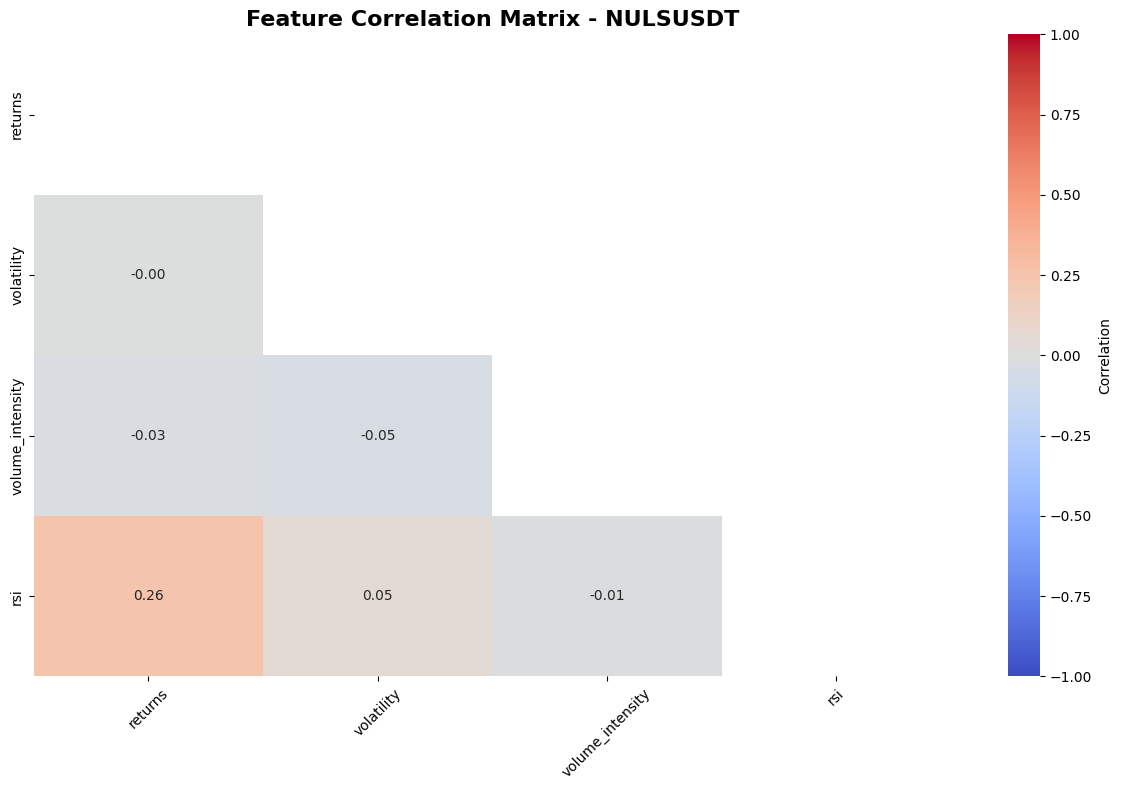

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

symbol = list(feature_dfs.keys())[0]  # first symbol
features = feature_dfs[symbol]

# correlation Heatmap
plt.figure(figsize=(12, 8))

corr_matrix = features.corr()

# craete heatmap
sns.heatmap(
    corr_matrix,
    annot=True,  # annotate with corr valuse
    fmt=".2f",   # limit to 2 decimal points
    mask=np.triu(np.ones_like(corr_matrix, dtype=bool)),  # show lower triangle
    cmap="coolwarm",  
    vmin=-1, vmax=1,  # correlation range
    center=0,
    cbar_kws={'label': 'Correlation'}  # add labels to color bar
)

plt.title(f'Feature Correlation Matrix - {symbol}', fontsize=16, weight='bold')
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### feature distributions
thoughts on feature distributions:
- returns are normally distributed
- volatility is skewed to the right
- volume intensity is skewed to the right
- rsi is almost normally distributed. i mean its around 49.5 so that's good not bad


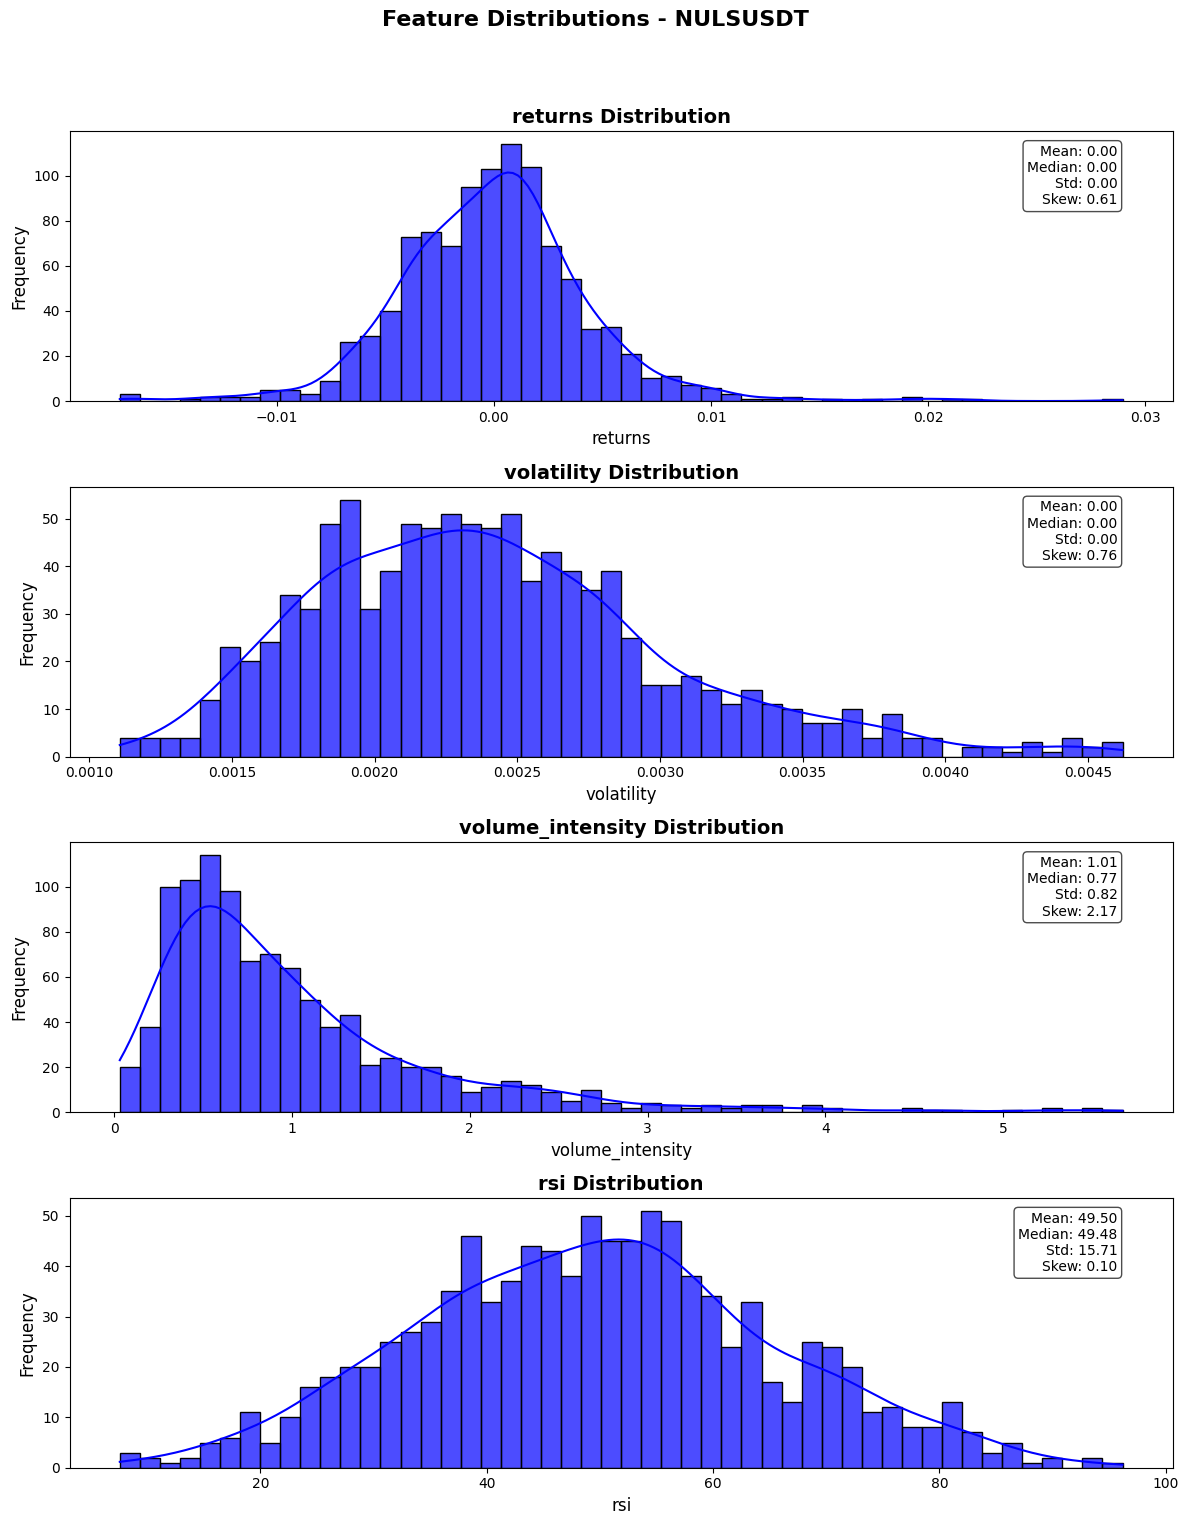

In [21]:
num_features = features.select_dtypes(include=np.number).columns  # Select numerical features
features_subset = features[num_features]  # Subset of numerical features

fig, axes = plt.subplots(len(features_subset.columns), 1, figsize=(12, len(features_subset.columns) * 4))

# Loop through features and plot histograms
for i, feature in enumerate(features_subset.columns):
    ax = axes[i]
    sns.histplot(features_subset[feature], bins=50, kde=True, ax=ax, color='blue', alpha=0.7)
    ax.set_title(f'{feature} Distribution', fontsize=14, weight='bold')
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

    # Add a text box with statistics
    mean = features_subset[feature].mean()
    median = features_subset[feature].median()
    std = features_subset[feature].std()
    skew = features_subset[feature].skew()
    ax.text(0.95, 0.95,
            f"Mean: {mean:.2f}\nMedian: {median:.2f}\nStd: {std:.2f}\nSkew: {skew:.2f}",
            transform=ax.transAxes,
            fontsize=10, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

plt.suptitle(f'Feature Distributions - {symbol}', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for suptitle
plt.show()